In [21]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
#显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
#显示负号
plt.rcParams['axes.unicode_minus']=False
#忽略警告
import warnings
warnings.filterwarnings("ignore")

In [20]:
import torch.nn as nn

In [59]:
#Classifier继承Module类
class Classifier(nn.Module):
    def __init__(self):
        #初始化Pytorch父类
        super().__init__() #调用父类的构造函数
        #定义神经网络层
        self.model=nn.Sequential(
            nn.Linear(784,200), #784->200
            # nn.LeakyReLU(0.02),       #S型激活函数
            nn.GELU(),
            nn.LayerNorm(200),  #标准化
            nn.Linear(200,10),  #200->10
            # nn.LeakyReLU(0.02)        #再次激活
            nn.Sigmoid()
        )
        #激活函数优化
        #Sigmoid函数:在输入值变大时，梯度会变得很小甚至消失 (~)
        #线性整流函数：ReLU() 负值斜率都为0，小于0的部分仍存在问题  (-/)
        #带泄漏线性整流函数：LeakyReLU(0.02)
        #GELU,类似于Relu,但提供了很好的梯度&原点周围没有尖锐的不连续性
        
        #loss优化
        #连续损失函数:均方误差:计算连续范围0-100
        # self.loss_function = nn.MSELoss()
        #离散损失函数:二元交叉熵损失：惩罚置信度高的错误输出&置信值低的正确输出
        #BCE只能处理0-1的值
        self.loss_function = nn.BCELoss()
        
        #反向传播梯度更新网络权重优化
        #随机梯度下降法：SGD,1.陷入损失函数局部最小值 2.单一学习率
        #Adam,解决上述缺点，利用动量，减少局部最小值的可能性，单独学习率随训练变化改变
        #更新权重,创建优化器，Adam
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters())
        
        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        
        pass
    #向网络传递信息
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    #训练网络
    def train(self, inputs, targets):
        #通过forward函数传递输入值给网络并计算网络输出值
        outputs = self.forward(inputs)
        #计算损失值
        loss = self.loss_function(outputs, targets)
        # #梯度归0，反向传播，并更新权重
        # self.optimiser.zero_grad() #梯度归0
        # loss.backward() #loss函数中计算网络中的梯度
        # self.optimiser.step() #使用这些梯度更新网络的可学习参数
        
        # #可视化
        # #记录训练进展的计数器&列表
        # self.counter=0
        # self.progress=[]
        #每隔10个训练样本增加一次计数器值,并添加损失值至列表末尾
        self.counter+=1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        #每10000次训练后打印计数器的值
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    #绘图
    def plot_progress(self):
        df=pd.DataFrame(self.progress,columns=['loss']) #损失值转换为DF
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,5))
        pass
    pass
    
        
    
        

In [60]:
from torch.utils.data import Dataset
class MnistDataset(Dataset):
    def __init__(self,csv_file):
        self.data_df=pd.read_csv(csv_file,header=None)
        pass
    #获取数据集大小
    def __len__(self):
        return len(self.data_df)
    #通过索引获取项目
    def __getitem__(self, index):
        #目标图像(label)
        label=self.data_df.iloc[index,0]
        target=torch.zeros((10)) #[1,0,0,0,0,0,0,0,0,0,0]独热码
        target[label]=1.0
        #图像数据,取值范围是0-255，标准化至0-1
        image_values=torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
        #返回label+图像数据张量+目标张量
        return label,image_values,target
    def plot_image(self,index):
        arr=self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title('label='+str(self.data_df.iloc[index,0]))
        plt.imshow(arr,interpolation='none',cmap='Blues')
        plt.show()
        pass
    pass

        

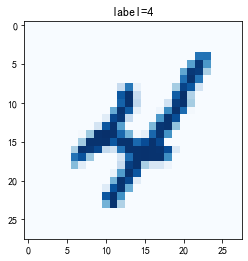

In [61]:
mnist_dataset=MnistDataset(r'D:\py\mnist_data\mnist_train.csv')
mnist_dataset.plot_image(9)

In [62]:
%%time
#训练分类器
#创建神经网络
C=Classifier()
#在mnist数据集训练神经网络
epochs=3
for i in range(epochs):
    print('training epoch',i+1,'of',epochs)
    for label,image_data_tensor,target_tensor in mnist_dataset:
        C.train(image_data_tensor,target_tensor)
        pass
    pass
    


training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: total: 30min 10s
Wall time: 7min 34s


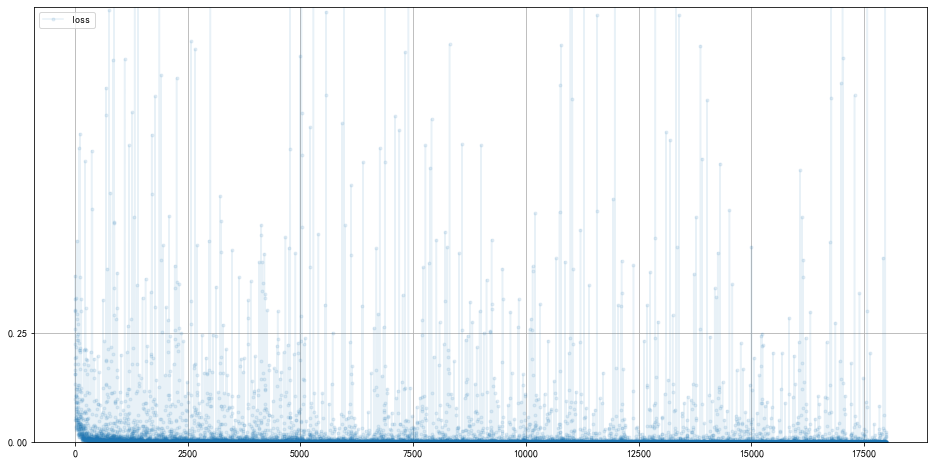

In [63]:
C.plot_progress()

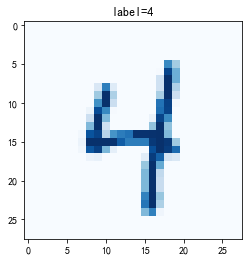

In [64]:
#加载测试集
mnist_test_dataset=MnistDataset(r'D:\py\mnist_data\mnist_test.csv')
#挑选一副图像
record=19
#绘制图像&标签
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

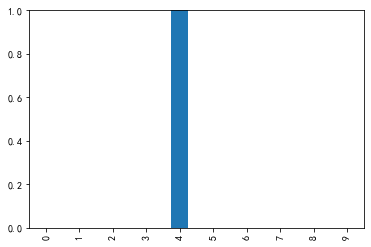

In [65]:
image_data=mnist_test_dataset[record][1]
#调用训练后的神经网络
output=C.forward(image_data)
#绘制输出张量
pd.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))

In [66]:
#简易分类器性能
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label): #answer.argmax()：输出张量最大值索引
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9734 10000 0.9734
